## Libraries

In [ ]:
from google.colab import files, drive
import os
import shutil
from PIL import Image
import sys
import glob
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomBrightness, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
!pip install keras_tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
# Delete Unzipped Unempty Directory containing Dataset
# Uncommend Code in case of need (e.g., need intact unzipped dataset)
# shutil.rmtree("./Plants_2")

## Global Variables

In [ ]:
# Choose Source of Dataset
DATASET_FROM_SCRATCH = False

# IF True: download, unzip, resize dataset from scratch
# Estimated time on free Colab instance is 20 mins

# IF False: download a saved previously preprocess dataset

In [ ]:
# Paths as Folder Structure
paths = ["Plants_2/train", "Plants_2/valid", "Plants_2/test"]
paths = [os.path.join(os.getcwd(), path) for path in paths]

In [ ]:
PATH_KEYWORD = 'diseased'
RESIZE_PIXELS = 512

In [ ]:
IMG_SIZE = 128 # Assumed Square Image IMG_SIZE x IMG_SIZE
SEED = 101

In [ ]:
EPOCHS = 50

## Functions

In [ ]:
# Function to Delete Subdirectories Selectively
def del_subdirs(path, keyword):
  paths_to_delete = [sd for sd in os.listdir(path) if keyword in sd]
  for p2d in paths_to_delete:
    shutil.rmtree(os.path.join(path, p2d))
  return

In [ ]:
# Function to Resize Images
def resize_images(size_pixels):
  i = 0
  for path_subdir in paths:
    for img_path in glob.iglob(path_subdir + '/*/*.JPG', recursive=True):
        img = Image.open(img_path)
        img_resized = img.resize((size_pixels, size_pixels), Image.NEAREST)
        img_path_resized = img_path[:-4] + " _resized" + img_path[-4:]
        img_resized.save(img_path_resized, 'JPEG', quality=90)
        os.remove(img_path)
        clear_output(wait=True)
        i += 1
        display('Images resized: ' + str(i))

In [ ]:
# Function to Build Deep Learning Model
def make_model(params):
  dropout_hp = params.Float("dropout", min_value=0.0, max_value=0.2, step=0.1)
  filters_hp = params.Choice("filters", values=[16, 32, 64])
  units_hp = params.Choice("units", values=[16, 32])
  model = Sequential(
      [
          Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
          RandomFlip("horizontal"),
          RandomRotation(0.2),
          RandomBrightness(0.2),
          Rescaling(scale=1/127.5, offset=-1),
          Conv2D(filters=filters_hp, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(dropout_hp),
          Conv2D(filters=2*filters_hp, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(dropout_hp),
          Conv2D(filters=4*filters_hp, kernel_size=3, padding="same", activation="relu"),
          MaxPooling2D(),
          Dropout(dropout_hp),
          Flatten(),
          Dense(units_hp),
          Dropout(2*dropout_hp),
          Dense(NUM_CLASSES),
          Softmax()
      ]
  )
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model


## Dataset

In [ ]:
# Mount Google Drive
# Required either way to save to OR read from the processed dataset
# Requires user permission
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prepare Dataset
if DATASET_FROM_SCRATCH:
  # Download Original Dataset and Perform All Preprocessing from Scratch
  print("SELECTED OPTION: Use Original Dataset")
  print("The original dataset approx 8 GB will be downloaded and processed")
  print("This procedure could take about 20 mins on a free Colab instance.")
  print("-----------------------------------------------------------------")

  # Upload Kaggle Credentials JSON File
  print("STEP 1: Upload Kaggle JSON Credintials")
  kaggle_token = files.upload()

  # Set Kaggle Directory Variable to Locate Kaggle Credentials
  os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

  # Download Kaggle Dataset
  print("STEP 2: Download Dataset")
  !kaggle datasets download -d csafrit2/plant-leaves-for-image-classification

  # Unzip Dataset
  print("STEP 3: Unzip Dataset")
  !unzip -q /content/plant-leaves-for-image-classification.zip

  # Delete Diseased Images
  print("STEP 4: Delete Certain Subdirectories")
  for path in paths:
    del_subdirs(path, PATH_KEYWORD)

  # Resize Images
  print("STEP 5: Resize Images")
  resize_images(RESIZE_PIXELS)

  # ZIP Processed Dataset
  print("STEP 6: Zip Processed Dataset")
  !zip -r -q /content/Plants_2.zip /content/Plants_2

  print("STEP 7: Save Processed Dataset to Drive")
  shutil.copy("/content/Plants_2.zip","/content/drive/MyDrive/")

else:
  # Use Previously Preprocessed Dataset, to save time
  print("SELECTED OPTION: Use Previously Preprocessed Dataset")
  !unzip -q /content/drive/MyDrive/Plants_2.zip -d /

SELECTED OPTION: Use Previously Preprocessed Dataset


## Model

In [ ]:
train_ds = image_dataset_from_directory(paths[0], image_size=(IMG_SIZE, IMG_SIZE)) # Default Batch Size: 32
val_ds = image_dataset_from_directory(paths[1], image_size=(IMG_SIZE, IMG_SIZE))
test_ds = image_dataset_from_directory(paths[2], image_size=(IMG_SIZE, IMG_SIZE))

Found 2163 files belonging to 11 classes.
Found 55 files belonging to 11 classes.
Found 55 files belonging to 11 classes.


In [ ]:
NUM_CLASSES = len(train_ds.class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(512).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tuner = kt.RandomSearch(make_model, objective="val_accuracy", max_trials=5, directory="grid_search")
tuner.search(train_ds, validation_data = val_ds, epochs = 10)

Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.7454545497894287

Best val_accuracy So Far: 0.7818182110786438
Total elapsed time: 00h 02m 34s


In [ ]:
best_params = tuner.get_best_hyperparameters()[0]
best_params.get_config()

{'space': [{'class_name': 'Float',
   'config': {'name': 'dropout',
    'default': 0.0,
    'conditions': [],
    'min_value': 0.0,
    'max_value': 0.2,
    'step': 0.1,
    'sampling': 'linear'}},
  {'class_name': 'Choice',
   'config': {'name': 'filters',
    'default': 16,
    'conditions': [],
    'values': [16, 32, 64],
    'ordered': True}},
  {'class_name': 'Choice',
   'config': {'name': 'units',
    'default': 16,
    'conditions': [],
    'values': [16, 32],
    'ordered': True}}],
 'values': {'dropout': 0.1, 'filters': 64, 'units': 32}}

In [ ]:
model = tuner.hypermodel.build(best_params)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 random_brightness_1 (Random  (None, 128, 128, 3)      0         
 Brightness)                                                     
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=10)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[earlystop])


Epoch 1/50
68/68 [==============================] - 6s 56ms/step - loss: 2.3115 - accuracy: 0.2483 - val_loss: 1.8471 - val_accuracy: 0.3455
Epoch 2/50
68/68 [==============================] - 3s 47ms/step - loss: 1.7207 - accuracy: 0.4087 - val_loss: 1.5692 - val_accuracy: 0.4000
Epoch 3/50
68/68 [==============================] - 3s 47ms/step - loss: 1.5585 - accuracy: 0.4545 - val_loss: 1.4920 - val_accuracy: 0.4727
Epoch 4/50
68/68 [==============================] - 3s 46ms/step - loss: 1.4710 - accuracy: 0.4864 - val_loss: 1.3233 - val_accuracy: 0.5273
Epoch 5/50
68/68 [==============================] - 3s 48ms/step - loss: 1.3409 - accuracy: 0.5488 - val_loss: 1.5058 - val_accuracy: 0.5091
Epoch 6/50
68/68 [==============================] - 3s 49ms/step - loss: 1.1767 - accuracy: 0.6172 - val_loss: 1.1312 - val_accuracy: 0.6545
Epoch 7/50
68/68 [==============================] - 3s 46ms/step - loss: 1.0803 - accuracy: 0.6389 - val_loss: 1.0376 - val_accuracy: 0.6364
Epoch 8/50
68

In [ ]:
results = model.evaluate(test_ds)
print("Loss: "+str(results[0])+" Accuracy: " + str(results[1]))

2/2 [==============================] - 0s 18ms/step - loss: 0.2839 - accuracy: 0.9636
Loss: 0.28389567136764526 Accuracy: 0.9636363387107849


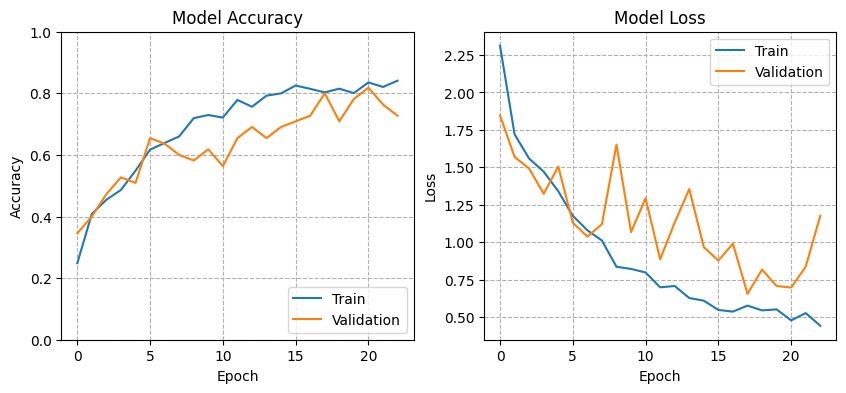

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.ylim(0,1)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
model.save("amd_cnn_model")